### **Code for Plotting European Option Binomial Trees** 

In [29]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_euro_binomial_option_tree(S0, u, d, result_dict, title="European Option Price Tree"):
    """
    Plot a European option binomial tree using the output from binomial_option_price().
    Includes a legend explaining the colour coding.
    
    Parameters
    ----------
    S0 : float
        Initial stock price.
    u : float
        Upward movement factor.
    d : float
        Downward movement factor.
    result_dict : dict
        Output from binomial_option_price(), must contain 'option_tree'.
    title : str
        Title for the plot.
    """
    option_tree = result_dict["option_tree"]
    N = len(option_tree) - 1
    C0 = option_tree[0][0]
    
    # Build stock price tree
    price_tree = [[S0 * (u**j) * (d**(i - j)) for j in range(i + 1)] for i in range(N + 1)]
    
    # Plot setup
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis("off")
    x_spacing, y_spacing = 1.0, 1.0
    
    for i, level in enumerate(price_tree):
        for j, price in enumerate(level):
            x = i * x_spacing
            y = j * y_spacing - (i * y_spacing / 2)
            opt_val = option_tree[i][j]
            
            # Colour based on option value relative to C0
            color = "dodgerblue" if opt_val >= C0 else "indianred"
            
            # Draw connecting lines
            if i < N:
                plt.plot([x, x + x_spacing],
                         [y, j * y_spacing - ((i + 1) * y_spacing / 2)],
                         color="gray", linewidth=1)
                plt.plot([x, x + x_spacing],
                         [y, (j + 1) * y_spacing - ((i + 1) * y_spacing / 2)],
                         color="gray", linewidth=1)
            
            # Draw node (stock + option value)
            label = f"{price:.2f}\n({opt_val:.2f})"
            plt.scatter(x, y, color=color, s=250, zorder=3, edgecolor="black")
            plt.text(x, y, label, fontsize=8, ha="center", va="center", color="white",
                     bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="none", alpha=0.9))
    
    # Add legend explaining colours
    legend_patches = [
        mpatches.Patch(color="dodgerblue", label="Node Value ≥ C₀"),
        mpatches.Patch(color="indianred", label="Node Value < C₀")
    ]
    plt.legend(handles=legend_patches, loc="upper left", frameon=False, fontsize=9)
    
    plt.tight_layout()
    plt.show()


### **European Option Call One-Step Binomial Model**

The code below implements the **one-step binomial tree model** for pricing a European call option.  
In this model, the initial stock price $ S_0 $ can either move **up** to $ S_0u $ or **down** to $ S_0d $ at time $ T $.  
The **risk-neutral probability** is calculated as:  

$
p = \frac{e^{rT} - d}{u - d},
$

which ensures that the expected return of the stock equals the risk-free rate $ r $.  
The option’s initial price $ C_0 $ is then obtained as the **discounted expected value** of the two possible payoffs $ C_u $ and $ C_d $:  

$
C_0 = e^{-rT}\,[pC_u + (1 - p)C_d].
$

The example below uses parameters from *Example 8.5* in the lecture notes and should produce a result close to  
$ C_0 \approx 1.266 $.

In [30]:
def one_step_call_price(S0, E, u, d, r, T):
    """Price a European call option using the one-step binomial model."""
    # Risk-neutral probability
    p = (math.exp(r * T) - d) / (u - d)
    
    # Payoffs at maturity
    Cu = max(S0 * u - E, 0)
    Cd = max(S0 * d - E, 0)
    
    # Discounted expected value
    C0 = math.exp(-r * T) * (p * Cu + (1 - p) * Cd)
    
    return {
        "Cu": round(Cu,3), "Cd": round(Cd,3),
        "p": round(p,5), "C0": round(C0,3)
    }

In [31]:
# Example 8.5 from the text
S0, E, u, d, r, T = 40, 42, 1.1, 0.9, 0.12, 0.25
result = one_step_call_price(S0, E, u, d, r, T)
print(result)

#Expected output: {'Cu': 2, 'Cd': 0, 'p': 0.65227, 'C0': 1.266}

{'Cu': 2.0, 'Cd': 0, 'p': 0.65227, 'C0': 1.266}


### **European Option Two-Step Binomial Model**

The following function extends the one-step framework to a **two-step binomial tree** for pricing both European call and put options.  
In this model, the total time to maturity $ T $ is divided into two equal steps of length $ t = \frac{T}{2} $.  
At each step, the stock price can move **up** by a factor $ u $ or **down** by a factor $ d $, producing three possible terminal prices after two periods:  
$ S_{0}u^{2} $, $ S_{0}ud $, and $ S_{0}d^{2} $.

The **risk-neutral probability** for each step is given by:  

$
p = \frac{e^{r t} - d}{u - d}.
$

At maturity, the option payoffs $ C_{uu} $, $ C_{ud} $, and $ C_{dd} $ (or $ P_{uu} $, $ P_{ud} $, $ P_{dd} $ for puts) are calculated from the corresponding terminal stock prices.  
The option’s initial value $ C_0 $ (or $ P_0 $) is then obtained by discounting the expected terminal payoff under the risk-neutral measure:  

$
C_0 = e^{-rT}\,[p^2 C_{uu} + 2p(1-p)C_{ud} + (1-p)^2 C_{dd}].
$

This example uses parameters from *Example 9.6* in the lecture notes to price a **two-step European put option**,  
which yields a theoretical result of approximately $ C_0 \approx 1.161 $.


In [32]:
def two_step_option_price(S0, E, u, d, r, T, option_type="call"):
    """Price a European option using a two-step binomial model."""
    t = T / 2
    p = (math.exp(r * t) - d) / (u - d)
    
    # Payoffs at maturity
    Suu = S0 * (u ** 2)
    Sud = S0 * u * d
    Sdd = S0 * (d ** 2)
    
    if option_type == "call":
        Cuu = max(Suu - E, 0)
        Cud = max(Sud - E, 0)
        Cdd = max(Sdd - E, 0)
    else:  # put option
        Cuu = max(E - Suu, 0)
        Cud = max(E - Sud, 0)
        Cdd = max(E - Sdd, 0)
    
    # Price at t=0
    C0 = math.exp(-r * T) * (
        (p ** 2) * Cuu +
        2 * p * (1 - p) * Cud +
        ((1 - p) ** 2) * Cdd
    )
    
    return {
        "p": round(p,5),
        "Cuu": round(Cuu,3), "Cud": round(Cud,3), "Cdd": round(Cdd,3),
        "C0": round(C0,3)
    }

In [33]:
# Example 9.6: Two-step put option
S0, E, r, T, u, d, N , option_type = 40, 32, 0.1, 0.5, 1.2, 0.8, 2 , "put"
result = two_step_option_price(S0, E, u, d, r, T, option_type)
print(result)

# Expected output: {'p': 0.56329, 'Cuu': 0, 'Cud': 0, 'Cdd': 6.4, 'C0': 1.161}

{'p': 0.56329, 'Cuu': 0, 'Cud': 0, 'Cdd': 6.4, 'C0': 1.161}


### **European Option Multi-Step (N-Step) Binomial Model**

The function below generalises the previous models to an **N-step binomial tree**, allowing the stock price to evolve over multiple discrete time steps.  
The total time to maturity $ T $ is divided into $ N $ intervals of equal length $ \Delta t = \frac{T}{N} $.  
At each step, the stock price can either move **up** by a factor $ u $ or **down** by a factor $ d $.  
This results in $ N + 1 $ possible stock prices at maturity, ranging from $ S_0 d^N $ to $ S_0 u^N $.

The **risk-neutral probability** for each step is given by:  

$
p = \frac{e^{r \Delta t} - d}{u - d}.
$

At maturity, the option payoffs are computed for all terminal stock prices:  
$ C_N = \max(S_N - E, 0) $ for calls, or $ P_N = \max(E - S_N, 0) $ for puts.  
The option value at earlier nodes is then found by working **backwards through the tree**, using the recursive relationship:  

$
C_i = e^{-r \Delta t}\,[p\,C_{i+1}^{(u)} + (1 - p)\,C_{i+1}^{(d)}].
$

After iterating back to the initial node, the final option price $ C_0 $ (or $ P_0 $) represents the fair market value under the risk-neutral measure.  

This example applies the method with $ N = 3 $ using the same parameters as *Example 8.5* in the lecture notes,  
producing a result of approximately $ C_0 \approx 2.44 $.


In [34]:
def euro_binomial_option_price(S0, E, r, T, u, d, N, option_type="call"):
    """Price a European option using an N-step binomial tree and return all intermediate values."""
    dt = T / N
    p = (math.exp(r * dt) - d) / (u - d)
    
    # Stock prices at maturity
    prices = [S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]
    
    # Option payoffs at maturity
    if option_type == "call":
        values = [max(price - E, 0) for price in prices]
    else:
        values = [max(E - price, 0) for price in prices]
    
    # Record the full tree (starting from final step)
    option_tree = [values]
    
    # Work backwards through the tree
    for i in range(N - 1, -1, -1):
        values = [
            math.exp(-r * dt) * (p * option_tree[0][j + 1] + (1 - p) * option_tree[0][j])
            for j in range(i + 1)
        ]
        option_tree.insert(0, values)  # add current layer to front
    
    return {
        "p": round(p, 5),
        "option_tree": option_tree,
        "option_price": round(option_tree[0][0], 3)
    }


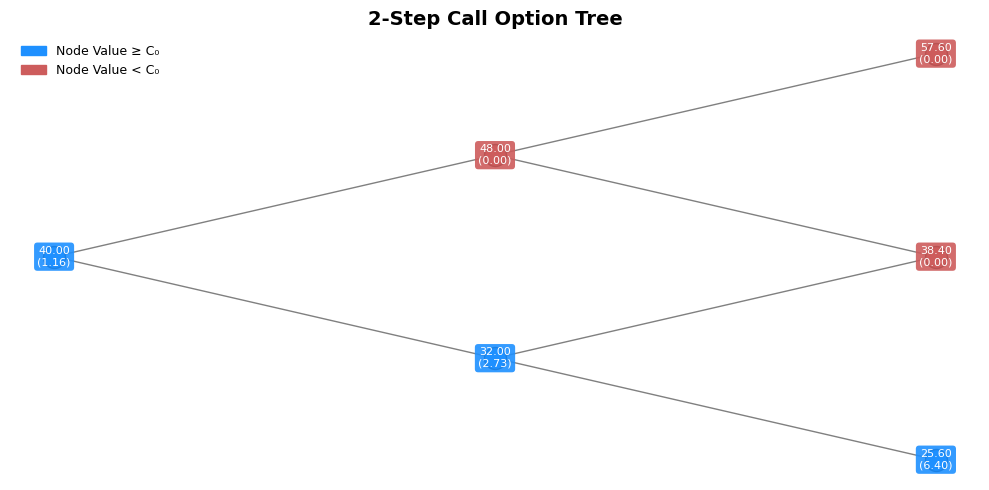

In [35]:
# Example 9.6: Two-step put option with "euro_binomial_option_price" and graph output

S0, E, r, T, u, d, N , option_type = 40, 32, 0.1, 0.5, 1.2, 0.8, 2 , "put"
result = (euro_binomial_option_price(S0, E, r, T, u, d, N, option_type))

plot_euro_binomial_option_tree(S0, u, d, result_dict=result, title=str(N) + "-Step Call Option Tree")

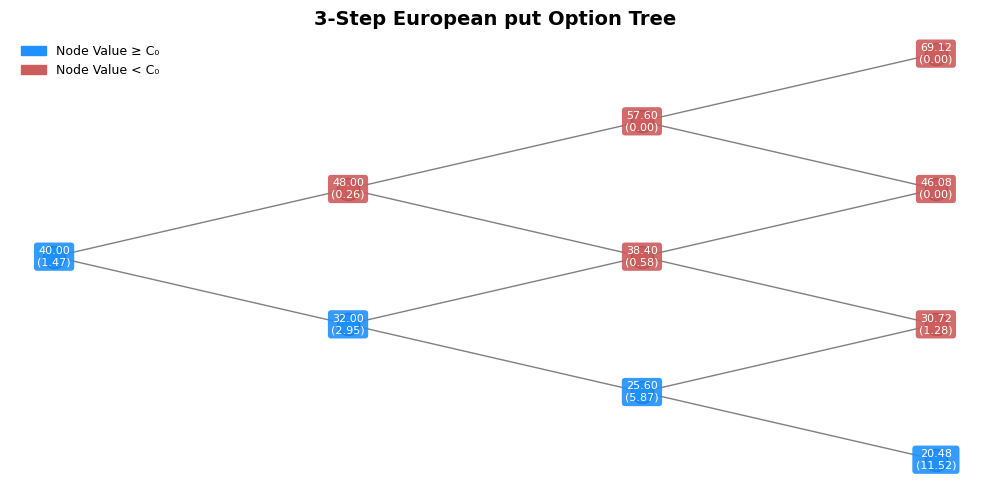

In [36]:
# Example: Multi-step call option (use same parameters as Example 9.6 but N=3)
S0, E, r, T, u, d, N , option_type = 40, 32, 0.1, 0.5, 1.2, 0.8, 3 , "put"
result = (euro_binomial_option_price(S0, E, r, T, u, d, N, option_type))

plot_euro_binomial_option_tree(S0, u, d, result_dict=result, title=str(N) + "-Step European " + option_type +" Option Tree")